In [17]:
import requests
from dotenv import load_dotenv
import os
load_dotenv()
import pandas as pd
from shroomdk import ShroomDK
from datetime import date


In [2]:
def get_magicTransfers():
    import pandas as pd
    import requests
    from shroomdk import ShroomDK
    import os
    from dotenv import load_dotenv
    load_dotenv

    FLIPSIDE_API_KEY = os.getenv(FLIPSIDE_API_KEY)
    page_num = 1
    pg_size = 100000
    sdk = ShroomDK(FLIPSIDE_API_KEY)

    sql_query = """
    Select
        tr.block_timestamp,
    tx_hash,
    origin_from_address,
    to_address,
    'MAGIC' as symbol,
    raw_amount/pow(10,18) as amount

    from arbitrum.core.fact_token_transfers tr
    where tr.contract_address = lower('0x539bdE0d7Dbd336b79148AA742883198BBF60342')
    order by tr.block_timestamp
    """

    page_num=1
    full_queries = True
    df=pd.DataFrame()

    while full_queries is True:

        query_result_set = sdk.query(
            sql_query,
            ttl_minutes=60,
            cached=True,
            timeout_minutes=20,
            retry_interval_seconds=1,
            page_size=pg_size,
            page_number=page_num
        )
        
        if query_result_set.run_stats.record_count > 0:
        
            df_new = pd.json_normalize(query_result_set.records)
            df = pd.concat([df, df_new], axis=0)
            page_num = page_num + 1
        else:
            full_queries = False
            break
    return df

In [3]:
df = get_magicTransfers()
df

,block_timestamp,tx_hash,origin_from_address,to_address,symbol,amount
0,2022-04-18 02:29:15.000,0x847184d4c5c80d1c2fdd7299d1c0638e3b026d0a40b6...,0x259b9c4cfeadaef8a5b842710a777364988415b3,0xb7e50106a5bd3cf21af210a755f9c8740890a8c9,MAGIC,198.55000
1,2022-04-18 02:29:15.000,0xfe752a163e23784b68db2cb6d28bd2bd9b9153752498...,0x9856b227b644718bd4a9f51522120fde65204991,0xdb6ab450178babcf0e467c1f3b436050d907e233,MAGIC,4.74500
2,2022-04-18 02:29:15.000,0xfe752a163e23784b68db2cb6d28bd2bd9b9153752498...,0x9856b227b644718bd4a9f51522120fde65204991,0xaaab5d6fbaab242c1c0828d378c01044c9f32061,MAGIC,90.15500
3,2022-04-18 03:21:40.000,0x1767c1f3a681f40843f2a5f7f8197e505e2e5078307b...,0x1c3f381b232b75ddb73becf5c3cd22737a52c56b,0xb7e50106a5bd3cf21af210a755f9c8740890a8c9,MAGIC,98.88000
4,2022-04-18 04:14:28.000,0xa71ae9ccfd90fd1c4129921a6ceda0943360d5e02a6a...,0x9db4f1c355cd9dccf22b8c571b9eca0a13ddd44c,0xdb6ab450178babcf0e467c1f3b436050d907e233,MAGIC,0.22500
...,...,...,...,...,...,...
99995,2022-09-19 10:09:19.000,0x1f3f906feb749ee80decbc89dec98228d0cf059c4492...,0xc00fc2775cce5b61ffd6ec1eec0de0119f25dc87,0x2b5321c1afddfb6680aafff4df96a209e18dea1c,MAGIC,17.07150
99996,2022-09-19 10:09:19.000,0x1f3f906feb749ee80decbc89dec98228d0cf059c4492...,0xc00fc2775cce5b61ffd6ec1eec0de0119f25dc87,0xe6db66725c3f50b8625e76822e0a58871c8a4a91,MAGIC,0.44925
99997,2022-09-19 10:09:19.000,0x1f3f906feb749ee80decbc89dec98228d0cf059c4492...,0xc00fc2775cce5b61ffd6ec1eec0de0119f25dc87,0xdb6ab450178babcf0e467c1f3b436050d907e233,MAGIC,0.44925
99998,2022-09-19 10:09:33.000,0x34df1b20f5dd2797e1cfab4877378264306cf0b29169...,0xa2225b86ccb530ac9a81d41a3d17ab643a9f7c8c,0xdb6ab450178babcf0e467c1f3b436050d907e233,MAGIC,0.17250


In [392]:
def activity_filterDateAndTxns(_df, date_list, tx_min_list):
    # 
    if _df == 'Get New':
        df = get_magicTransfers()
    else:
        df = _df
    interactions_date_filtered = dict()    
    god = dict()
    
    df['date'] = pd.to_datetime(df['block_timestamp']).dt.date
    df_test = df[['date', 'tx_hash', 'origin_from_address', 'amount']]
    
    dm_list = []
    for date_item in date_list:
        dft=pd.DataFrame()
        filter_time = date_item
        date_mask = df_test['date'] >= date.today() - pd.Timedelta(days=filter_time)
        dft_date = df_test[date_mask].copy()
        
        dft=dft_date.groupby('origin_from_address')['tx_hash'].count().reset_index()
        
        
        interactions_date_filtered.update({date_item:dft})
        # dm_list.append(
        
        num_active_list = {}
        
    for tx_min in tx_min_list:
        print(f'---------------------Min # Txns: {tx_min}------------------\n')
        for k in interactions_date_filtered:
            print(f'# Days:{k}\nMin Txns:{tx_min}------------------\n')
            dm=interactions_date_filtered[k]
            tx_min_filter = dm['tx_hash'] >= tx_min
            active_accounts = dm[tx_min_filter]
            num_active = len(set(active_accounts['origin_from_address'].values))
            
            # print(f'Updating god with: {k} and {tx_min}')
            god.update({(k, tx_min) : {'min_txns': tx_min, 'timeframe': k, 'num_active':num_active}})
    print('We have god!')
    print(god)
    return god
#         for dm in dm_list:
#             tx_min_filter = dm['tx_hash'] >= tx_min
#             active_accounts = dft_date[tx_filter].sort_values('tx_hash', ascending=False)
#             num_active = len(set(active_accounts['origin_from_address'].values))
            
#             num_active_list = {():{'min_tx': 
            
#             tx_mask_list.append(tx_min_filter)

#     filter_time = 21
#     tx_min = 10

#     date_mask = (df['date'] > date.today() - pd.Timedelta(days=filter_time))
#     dft_date = df[date_mask].groupby('origin_from_address')['tx_hash'].count().reset_index()

#     dft_date

#     tx_filter = dft_date['tx_hash'] >= tx_min
#     active_accounts = dft_date[tx_filter].sort_values('tx_hash', ascending=False)
#     active_accounts

#     num_active = len(set(active_accounts['origin_from_address'].values))

In [381]:
date_list = [1,3,7,14,21,30,45,60,90]
tx_min_list = [1, 10, 50, 100, 200]

result = activity_filterDateAndTxns('Get New', date_list, tx_min_list)
result

---------------------Min # Txns: 1------------------

# Days:1
Min Txns:1------------------

# Days:3
Min Txns:1------------------

# Days:7
Min Txns:1------------------

# Days:14
Min Txns:1------------------

# Days:21
Min Txns:1------------------

# Days:30
Min Txns:1------------------

# Days:45
Min Txns:1------------------

# Days:60
Min Txns:1------------------

# Days:90
Min Txns:1------------------

---------------------Min # Txns: 10------------------

# Days:1
Min Txns:10------------------

# Days:3
Min Txns:10------------------

# Days:7
Min Txns:10------------------

# Days:14
Min Txns:10------------------

# Days:21
Min Txns:10------------------

# Days:30
Min Txns:10------------------

# Days:45
Min Txns:10------------------

# Days:60
Min Txns:10------------------

# Days:90
Min Txns:10------------------

---------------------Min # Txns: 50------------------

# Days:1
Min Txns:50------------------

# Days:3
Min Txns:50------------------

# Days:7
Min Txns:50-------------

{(1, 1): {'min_txns': 1, 'timeframe': 1, 'num_active': 0},
 (3, 1): {'min_txns': 1, 'timeframe': 3, 'num_active': 0},
 (7, 1): {'min_txns': 1, 'timeframe': 7, 'num_active': 0},
 (14, 1): {'min_txns': 1, 'timeframe': 14, 'num_active': 0},
 (21, 1): {'min_txns': 1, 'timeframe': 21, 'num_active': 23965},
 (30, 1): {'min_txns': 1, 'timeframe': 30, 'num_active': 43680},
 (45, 1): {'min_txns': 1, 'timeframe': 45, 'num_active': 51423},
 (60, 1): {'min_txns': 1, 'timeframe': 60, 'num_active': 55505},
 (90, 1): {'min_txns': 1, 'timeframe': 90, 'num_active': 59003},
 (1, 10): {'min_txns': 10, 'timeframe': 1, 'num_active': 0},
 (3, 10): {'min_txns': 10, 'timeframe': 3, 'num_active': 0},
 (7, 10): {'min_txns': 10, 'timeframe': 7, 'num_active': 0},
 (14, 10): {'min_txns': 10, 'timeframe': 14, 'num_active': 0},
 (21, 10): {'min_txns': 10, 'timeframe': 21, 'num_active': 874},
 (30, 10): {'min_txns': 10, 'timeframe': 30, 'num_active': 1748},
 (45, 10): {'min_txns': 10, 'timeframe': 45, 'num_active': 2

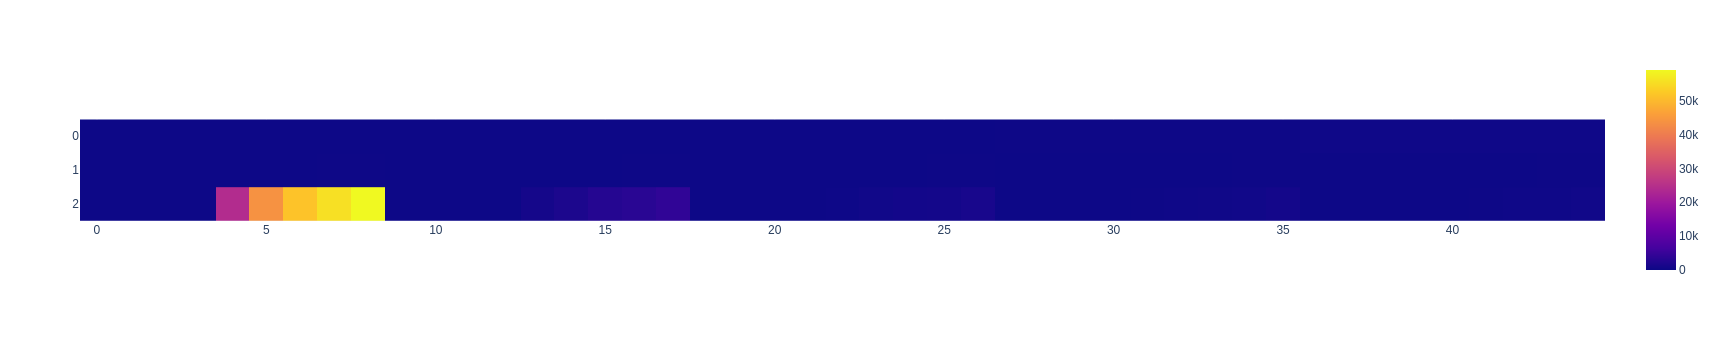

In [399]:
df_matrix = pd.DataFrame.from_dict(result).T
matrix = df_matrix.to_numpy()

fig = px.imshow(matrix.T)
fig.show()

In [116]:
result[90, 100]

{'min_txns': 100, 'timeframe': 90, 'num_active': 816}

In [376]:
df_activity = pd.DataFrame.from_dict(result)
mask = df_activity['num_active']>0
df_activity[mask].to_numpy()

KeyError: 'num_active'

In [110]:
result['dataframe'][1]

1      Empty DataFrame
Columns: [origin_from_address,...
10     Empty DataFrame
Columns: [origin_from_address,...
50     Empty DataFrame
Columns: [origin_from_address,...
100    Empty DataFrame
Columns: [origin_from_address,...
200    Empty DataFrame
Columns: [origin_from_address,...
Name: dataframe, dtype: object

In [ ]:
dfs = result

# Keep the Addresses of the active Users
---

In [401]:
def activity_filteredByDateAndTxns(_df, date_list, tx_min_list):
    # 
    if _df == 'Get New':
        df = get_magicTransfers()
    else:
        df = _df
    interactions_date_filtered = dict()    
    god = dict()
    
    df['date'] = pd.to_datetime(df['block_timestamp']).dt.date
    df_test = df[['date', 'tx_hash', 'origin_from_address', 'amount']]
    
    dm_list = []
    for date_item in date_list:
        dft=pd.DataFrame()
        filter_time = date_item
        date_mask = df_test['date'] > date.today() - pd.Timedelta(days=filter_time)
        dft_date = df_test[date_mask].copy()
        
        dft=dft_date.groupby('origin_from_address')['tx_hash'].count().reset_index()
        
        dft['interval_filter']=date_item
        
        for tx_min in tx_min_list:
            mask = dft['tx_hash']>=tx_min
            masked_df =dft[mask]
            
            address_list = np.array(((masked_df['origin_from_address'].unique())))
            num_active = len(address_list)
            
            god.update({(tx_min, date_item) : {'num_active': num_active, 'addresses': address_list}})
    
    return pd.DataFrame(god).T

#         interactions_date_filtered.update({date_item:dft})
#         dm_list.append(
        
#         num_active_list = {}
        
#     for tx_min in tx_min_list:
#         print(f'---------------------Min # Txns: {tx_min}------------------\n')
#         for k in interactions_date_filtered:
#             print(f'# Days:{k}\nMin Txns:{tx_min}------------------\n')
#             dm=interactions_date_filtered[k]
#             tx_min_filter = dm['tx_hash'] >= tx_min
#             active_accounts = dm[tx_min_filter]
#             num_active = len(set(active_accounts['origin_from_address'].values))
            
#             # print(f'Updating god with: {k} and {tx_min}')
#             god.update({(k, tx_min) : {'min_txns': tx_min, 'timeframe': k, 'num_active':num_active}})
#     print('We have god!')
#     print(god)
#     return god
            
            
            
            
            
            
            
#         for dm in dm_list:
#             tx_min_filter = dm['tx_hash'] >= tx_min
#             active_accounts = dft_date[tx_filter].sort_values('tx_hash', ascending=False)
#             num_active = len(set(active_accounts['origin_from_address'].values))
            
#             num_active_list = {():{'min_tx': 
            
#             tx_mask_list.append(tx_min_filter)

#     filter_time = 21
#     tx_min = 10

#     date_mask = (df['date'] > date.today() - pd.Timedelta(days=filter_time))
#     dft_date = df[date_mask].groupby('origin_from_address')['tx_hash'].count().reset_index()

#     dft_date

#     tx_filter = dft_date['tx_hash'] >= tx_min
#     active_accounts = dft_date[tx_filter].sort_values('tx_hash', ascending=False)
#     active_accounts

#     num_active = len(set(active_accounts['origin_from_address'].values))

In [228]:
import timeit
import numpy as np
date_list = [14,30,90]
tx_min_list = [1, 50, 100]

first_timer =timeit.default_timer()
result = activity_filteredByDateAndTxns('Get New', date_list, tx_min_list)
second_timer =timeit.default_timer()

code_time = second_timer - first_timer


print(f'The code took {code_time} to execute')

The code took 32.060693055042066 to execute


In [257]:
pd.DataFrame(result)

,1,50,100,1,50,100,1,50,100
,14,14,14,30,30,30,90,90,90
num_active,597,7,1,46507,493,267,61594,1301,816
addresses,"[0x008d3aad83462283a105fe590a42197864d0fb7c, 0...","[0x14b30b46ec4fa1a993806bd5dda4195c5a82353e, 0...",[0x3897eeff99435b115ccb975984ce2bba96c92679],"[0x0000000000000000000000000000000000000000, 0...","[0x008d3aad83462283a105fe590a42197864d0fb7c, 0...","[0x02736d5c8dcea65539993d143a3de90cebca9c3c, 0...","[0x0000000000000000000000000000000000000000, 0...","[0x000000000d71b31f9c460f26c45589ec91551969, 0...","[0x000000000d71b31f9c460f26c45589ec91551969, 0..."


In [263]:
funnel = pd.DataFrame(result).T
funnel

,,num_active,addresses
1,14,597,"[0x008d3aad83462283a105fe590a42197864d0fb7c, 0..."
50,14,7,"[0x14b30b46ec4fa1a993806bd5dda4195c5a82353e, 0..."
100,14,1,[0x3897eeff99435b115ccb975984ce2bba96c92679]
1,30,46507,"[0x0000000000000000000000000000000000000000, 0..."
50,30,493,"[0x008d3aad83462283a105fe590a42197864d0fb7c, 0..."
100,30,267,"[0x02736d5c8dcea65539993d143a3de90cebca9c3c, 0..."
1,90,61594,"[0x0000000000000000000000000000000000000000, 0..."
50,90,1301,"[0x000000000d71b31f9c460f26c45589ec91551969, 0..."
100,90,816,"[0x000000000d71b31f9c460f26c45589ec91551969, 0..."


In [293]:
# funnel.reset_index(inplace=True)
no_filter = funnel.loc[1,:].reset_index()
filter_50 = funnel.loc[50, :].reset_index()

df1 = no_filter[['index', 'num_active']].to_dict()
df2 = filter_50[['index', 'num_active']].to_dict()
# dict_1 = no_filter.to_dict()
# dict_2 = filter_50.to_dict()

# dict_1

### Create a Funnel Plot

In [296]:

# mask_date = funnel['level_1']==30
# mask = mask_txn & mask_date

pd.Series(df1['index'])
# print(f'y: {y}\nx: {x}')

0    14
1    30
2    90
dtype: int64

In [372]:
df1

{'level_0': {0: 0, 1: 1, 2: 2},
 'index': {0: 14, 1: 30, 2: 90},
 'num_active': {0: 597, 1: 46507, 2: 61594}}

In [367]:
# np.array(df1['num_active'].items())
dd= list(df1['num_active'].values()).reverse()
list(reversed(list(df1['num_active'].values())))

[61594, 46507, 597]

In [366]:
dd

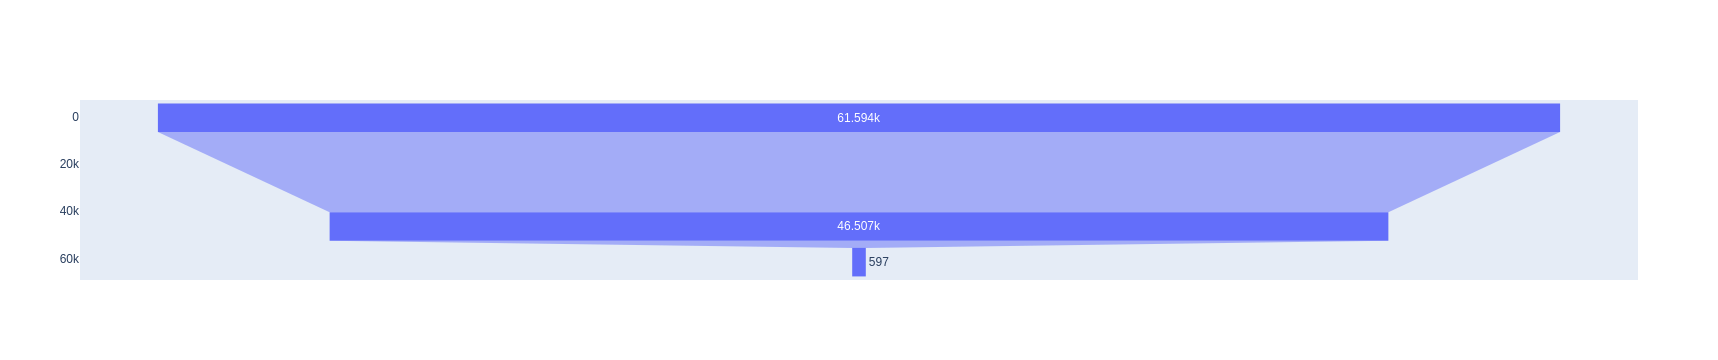

In [375]:
import plotly.express as px
import pandas as pd

no_filter = funnel.loc[1,:].reset_index()
filter_50 = funnel.loc[50, :].reset_index()

df1 = no_filter[['index', 'num_active']].reset_index()
df1= df1.to_dict()
df2 = filter_50[['index', 'num_active']].reset_index()
df2= df2.to_dict()

x1 = list(reversed(list(df1['num_active'].values())))
y1 = list(df1['num_active'].values())

x2=list(reversed(list(df2['num_active'].values())))
y2=list(df2['num_active'].values())

f1 = go.Funnel(x=x1, y=y1)
# f2 = go.Funnel(x=x2, y=y2)

data=f1
go.Figure(data)


###Filtered at a min of 50 txns
# mask_txn = funnel['level_0']==50
# mask = mask_txn

# df=funnel[mask].sort_values('num_active', ascending=False).copy()
# y=df['level_1'].values
# x=df['num_active'].values


stages = ['90 Days', '30 Days','14 Days']
active_addresses = [100, 10000, 50000]


# no_mask = funnel['level_0']==1
# df_no_min = funnel[no_mask].sort_values('num_active', ascending=False).copy()
# y_no_min=df_min['level_1'].values
# x_no_min=df_min['num_active'].values

# funnel


# df_funnel_dict=df_funnel[['level_1', 'num_active']].rename(columns={'level_1':'days'}).to_dict()
# x1=np.array(df_funnel_dict['days'])
# df_funnel_no_min_dict = df_funnel_no_min[['level_1', 'num_active']].rename(columns={'level_1':'days'}).to_dict()
# import plotly.express as px
# import plotly.graph_objects as go

# fig = go.Figure()

# df_funnel = df[['level_1', 'num_active']]
# df_funnel_no_min = df_no_min[['level_1', 'num_active']]


# # data = dict(
# #     number=active_addresses,
# #     stage = stages)
# # df = funnel[mask]
# # df=pd.DataFrame(d).sort_values('number', ascending= False)
# # stage=["Website visit", "Downloads", "Potential customers", "Requested price", "invoice sent"])



# stages = ["Website visit", "Downloads", "Potential customers", "Requested price", "invoice sent"]
# df_mtl = pd.DataFrame(dict(number=[39, 27.4, 20.6, 11, 3], stage=stages))
# df_mtl['office'] = 'Montreal'
# df_toronto = pd.DataFrame(dict(number=[52, 36, 18, 14, 5], stage=stages))
# df_toronto['office'] = 'Toronto'
# df = pd.concat([df_mtl, df_toronto], axis=0)
# fig = px.funnel(df, x='number', y='stage', color='office')
# fig.show()

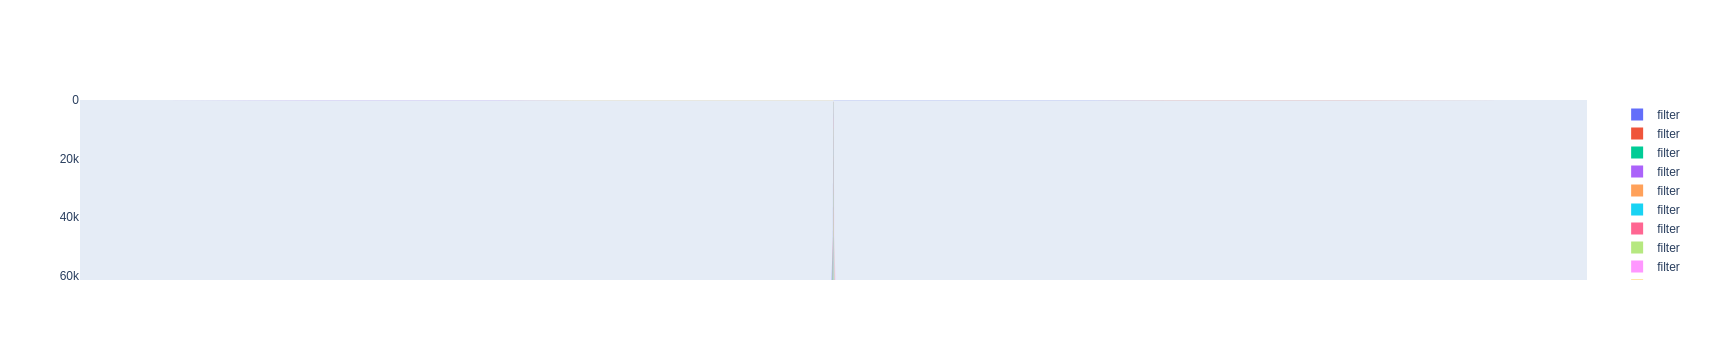

In [353]:
fig.show()